In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from IPython.core.display import display, HTML
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline

plt.style.use('fivethirtyeight')
display(HTML("<style>.container { width:80% !important; }</style>"))

# Read input files

In [2]:
# Decided to use both input dataset 1 and 2 to get more data to train on
#df = pd.read_parquet("../container-data/input_dataset-1.parquet")
df = pd.read_parquet("../container-data/input_dataset-2.parquet")
pred_df = pd.read_parquet("../container-data/prediction_input.parquet")

In [3]:
pred_cols = ["Bolt_"+str(x)+"_Tensile" for x in range(1,7)]+list(pred_df.columns)
pred_cols

['Bolt_1_Tensile',
 'Bolt_2_Tensile',
 'Bolt_3_Tensile',
 'Bolt_4_Tensile',
 'Bolt_5_Tensile',
 'Bolt_6_Tensile',
 'Unit_4_Power',
 'Unit_4_Reactive Power',
 'Turbine_Guide Vane Opening',
 'Turbine_Pressure Drafttube',
 'Turbine_Pressure Spiral Casing',
 'Turbine_Rotational Speed',
 'mode']

In [4]:
#df = pd.concat([df1.loc[:,pred_cols], df2.loc[:,pred_cols]], axis=0)

In [5]:
#df.to_pickle("../container-data/df.pkl")

In [6]:
#df = pd.read_pickle("../container-data/df.pkl")
df = df.loc[:,pred_cols]

In [7]:
df.columns

Index(['Bolt_1_Tensile', 'Bolt_2_Tensile', 'Bolt_3_Tensile', 'Bolt_4_Tensile',
       'Bolt_5_Tensile', 'Bolt_6_Tensile', 'Unit_4_Power',
       'Unit_4_Reactive Power', 'Turbine_Guide Vane Opening',
       'Turbine_Pressure Drafttube', 'Turbine_Pressure Spiral Casing',
       'Turbine_Rotational Speed', 'mode'],
      dtype='object')

In [8]:
df = df.dropna()

In [9]:
start_time = df.index.min()
start_time

Timestamp('1970-12-19 09:51:44')

In [10]:
df.head()

,Bolt_1_Tensile,Bolt_2_Tensile,Bolt_3_Tensile,Bolt_4_Tensile,Bolt_5_Tensile,Bolt_6_Tensile,Unit_4_Power,Unit_4_Reactive Power,Turbine_Guide Vane Opening,Turbine_Pressure Drafttube,Turbine_Pressure Spiral Casing,Turbine_Rotational Speed,mode
timepoints,,,,,,,,,,,,,
1970-12-19 09:51:44,1598.481390,1480.989917,1684.247079,1601.359944,1635.585700,1674.848803,262.204308,2.899036,82.279976,173.955216,5310.799181,107.964278,operation
1970-12-19 09:51:45,1598.477449,1480.989528,1684.261611,1601.366508,1635.588478,1674.823883,262.104319,3.344630,82.277248,173.989815,5311.219755,107.964273,operation
1970-12-19 09:51:46,1598.479316,1481.003188,1684.270504,1601.374254,1635.583464,1674.841318,262.004330,3.790223,82.274520,174.024413,5311.640329,107.964269,operation
1970-12-19 09:51:47,1598.490184,1481.028827,1684.270683,1601.383179,1635.581384,1674.843245,261.904340,4.235817,82.271792,174.059012,5312.060902,107.964264,operation
1970-12-19 09:51:48,1598.494073,1481.059017,1684.271062,1601.378391,1635.591746,1674.872300,261.804351,4.064759,82.269064,174.153819,5312.405938,107.964259,operation


In [11]:
df["datetime"] = df.index.values

Want to make a holdout dataset for validation. This is held separate from crossvalidation.

The holdout-set is chosen as 20% of the data. (Not chunked in time.)

Argue that we do not get data leakage from the future, but get better validation that we are able to model dependencies across the whole dataset. 

In [12]:
def split_trn_val(df, frac=0.2):
    df = df.copy()
    df.index = np.arange(len(df))
    val_inds = np.random.choice(df.index.values, size=int(len(df)*frac), replace=False)
    val_df = df.iloc[df.index.isin(val_inds)]
    trn_df = df.iloc[~df.index.isin(val_inds)]
    return trn_df, val_df

In [13]:
trn_df, val_df = split_trn_val(df)

In [91]:
#trn_df.to_pickle("../container-data/trn_df.pkl")

In [92]:
#val_df.to_pickle("../container-data/val_df.pkl")

In [14]:
y_cols = ["Bolt_"+str(count)+"_Tensile" for count in range(1,7)]
y_cols

['Bolt_1_Tensile',
 'Bolt_2_Tensile',
 'Bolt_3_Tensile',
 'Bolt_4_Tensile',
 'Bolt_5_Tensile',
 'Bolt_6_Tensile']

In [15]:
drop_cols = ["datetime"]

In [18]:
def binarize_mode(df):
    df["mode"] = df["mode"].apply(lambda x: 1 if x=="start" else 0)
    return df

def add_mode_switch(df):
    df["mode_switch"] = df["mode"]-(df["mode"].shift(fill_value=False))
    return df

def add_sec_since_switch(df):
    df["sec_since_switch"] = (df.groupby('mode')['datetime'].transform(lambda x: (x-x.min()).dt.seconds))
    return df

def add_days_since_start(df):
    df["days_since_start"] = (df["datetime"]-start_time).dt.days
    return df

def add_rolling_sum_speed(df, periods=[60,60*5, 60*60]):
    for period in periods:
        df["Turbine_Rotational Speed_sum"+str(period)] = df["Turbine_Rotational Speed"].rolling(period, min_periods=1).sum()
    return df

def remove_cols(df):
    df = df.drop(drop_cols, axis=1)
    return df

def split_x_y(df):
    X = df.drop(y_cols, axis=1)
    y = df.loc[:, y_cols]
    return X, y

def preprocessing(df):
    df = binarize_mode(df)
    df = add_mode_switch(df)
    df = add_sec_since_switch(df)
    df = add_days_since_start(df)
    #df = add_rolling_sum_speed(df)
    df = remove_cols(df)
    X, y = split_x_y(df)
    return X, y

In [19]:
df_X_train, df_y_train = preprocessing(trn_df)

In [20]:
df_X_val, df_y_val = preprocessing(val_df)

In [21]:
x_cols = set([x for x in df_X_train.columns])-set(y_cols)
x_cols

{'Turbine_Guide Vane Opening',
 'Turbine_Pressure Drafttube',
 'Turbine_Pressure Spiral Casing',
 'Turbine_Rotational Speed',
 'Unit_4_Power',
 'Unit_4_Reactive Power',
 'days_since_start',
 'mode',
 'mode_switch',
 'sec_since_switch'}

# Cross-validation

In [22]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_percentage_error

kf = KFold(n_splits=3, random_state=42, shuffle=True)
#models = [DecisionTreeRegressor(max_depth=5) for _ in y_cols]


fold = 1
scores = {}
preds = {}
residuals = {}
trained_models = {}
for train_index, test_index in kf.split(df_X_train):
    scores[fold] = {}
    preds[fold] = {}
    residuals[fold] = {}
    trained_models[fold] = {}
    print(fold)
    X_train, X_test = df_X_train.iloc[train_index], df_X_train.iloc[test_index]
    for y in y_cols:
        print(y)
        scores[fold][y] = {}
        preds[fold][y] = {}
        residuals[fold][y] = {}
        trained_models[fold][y] = {}
        drop_cols = [x for x in y_cols if x!=y]
        print(drop_cols)
        y_train, y_test = df_y_train.iloc[train_index].drop(drop_cols, axis=1).values().flatten(), df_y_train.iloc[test_index].drop(drop_cols, axis=1)
        models = [RandomForestRegressor(n_estimators=5, n_jobs=4)]
        for model in models:
            model_name = str(type(model).__name__)
            print(model_name)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            score = mean_absolute_percentage_error(y_test, y_pred, multioutput="raw_values")
            print(score)
            scores[fold][y][model_name] = score
            preds[fold][y][model_name] = y_pred
            residuals[fold][y][model_name] = y_pred-y_test.values.flatten()
            trained_models[fold][y][model_name] = model
            break
    fold = fold+1

1
Bolt_1_Tensile
['Bolt_2_Tensile', 'Bolt_3_Tensile', 'Bolt_4_Tensile', 'Bolt_5_Tensile', 'Bolt_6_Tensile']
RandomForestRegressor


C:\Users\TTHORE~1\AppData\Local\Temp/ipykernel_30608/1151199750.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


[9.67698634e-06]
Bolt_2_Tensile
['Bolt_1_Tensile', 'Bolt_3_Tensile', 'Bolt_4_Tensile', 'Bolt_5_Tensile', 'Bolt_6_Tensile']
RandomForestRegressor


C:\Users\TTHORE~1\AppData\Local\Temp/ipykernel_30608/1151199750.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


[1.12313805e-05]
Bolt_3_Tensile
['Bolt_1_Tensile', 'Bolt_2_Tensile', 'Bolt_4_Tensile', 'Bolt_5_Tensile', 'Bolt_6_Tensile']
RandomForestRegressor


C:\Users\TTHORE~1\AppData\Local\Temp/ipykernel_30608/1151199750.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


[6.49771658e-06]
Bolt_4_Tensile
['Bolt_1_Tensile', 'Bolt_2_Tensile', 'Bolt_3_Tensile', 'Bolt_5_Tensile', 'Bolt_6_Tensile']
RandomForestRegressor


C:\Users\TTHORE~1\AppData\Local\Temp/ipykernel_30608/1151199750.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


[8.2268608e-06]
Bolt_5_Tensile
['Bolt_1_Tensile', 'Bolt_2_Tensile', 'Bolt_3_Tensile', 'Bolt_4_Tensile', 'Bolt_6_Tensile']
RandomForestRegressor


C:\Users\TTHORE~1\AppData\Local\Temp/ipykernel_30608/1151199750.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


[9.58872684e-06]
Bolt_6_Tensile
['Bolt_1_Tensile', 'Bolt_2_Tensile', 'Bolt_3_Tensile', 'Bolt_4_Tensile', 'Bolt_5_Tensile']
RandomForestRegressor


C:\Users\TTHORE~1\AppData\Local\Temp/ipykernel_30608/1151199750.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


[1.36112128e-05]
2
Bolt_1_Tensile
['Bolt_2_Tensile', 'Bolt_3_Tensile', 'Bolt_4_Tensile', 'Bolt_5_Tensile', 'Bolt_6_Tensile']
RandomForestRegressor


C:\Users\TTHORE~1\AppData\Local\Temp/ipykernel_30608/1151199750.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


[9.70619342e-06]
Bolt_2_Tensile
['Bolt_1_Tensile', 'Bolt_3_Tensile', 'Bolt_4_Tensile', 'Bolt_5_Tensile', 'Bolt_6_Tensile']
RandomForestRegressor


C:\Users\TTHORE~1\AppData\Local\Temp/ipykernel_30608/1151199750.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


[1.12035404e-05]
Bolt_3_Tensile
['Bolt_1_Tensile', 'Bolt_2_Tensile', 'Bolt_4_Tensile', 'Bolt_5_Tensile', 'Bolt_6_Tensile']
RandomForestRegressor


C:\Users\TTHORE~1\AppData\Local\Temp/ipykernel_30608/1151199750.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


[6.51808693e-06]
Bolt_4_Tensile
['Bolt_1_Tensile', 'Bolt_2_Tensile', 'Bolt_3_Tensile', 'Bolt_5_Tensile', 'Bolt_6_Tensile']
RandomForestRegressor


C:\Users\TTHORE~1\AppData\Local\Temp/ipykernel_30608/1151199750.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


[8.20863462e-06]
Bolt_5_Tensile
['Bolt_1_Tensile', 'Bolt_2_Tensile', 'Bolt_3_Tensile', 'Bolt_4_Tensile', 'Bolt_6_Tensile']
RandomForestRegressor


C:\Users\TTHORE~1\AppData\Local\Temp/ipykernel_30608/1151199750.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


[9.52425331e-06]
Bolt_6_Tensile
['Bolt_1_Tensile', 'Bolt_2_Tensile', 'Bolt_3_Tensile', 'Bolt_4_Tensile', 'Bolt_5_Tensile']
RandomForestRegressor


C:\Users\TTHORE~1\AppData\Local\Temp/ipykernel_30608/1151199750.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


[1.35696132e-05]
3
Bolt_1_Tensile
['Bolt_2_Tensile', 'Bolt_3_Tensile', 'Bolt_4_Tensile', 'Bolt_5_Tensile', 'Bolt_6_Tensile']
RandomForestRegressor


C:\Users\TTHORE~1\AppData\Local\Temp/ipykernel_30608/1151199750.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


[9.63695534e-06]
Bolt_2_Tensile
['Bolt_1_Tensile', 'Bolt_3_Tensile', 'Bolt_4_Tensile', 'Bolt_5_Tensile', 'Bolt_6_Tensile']
RandomForestRegressor


C:\Users\TTHORE~1\AppData\Local\Temp/ipykernel_30608/1151199750.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


[1.11798958e-05]
Bolt_3_Tensile
['Bolt_1_Tensile', 'Bolt_2_Tensile', 'Bolt_4_Tensile', 'Bolt_5_Tensile', 'Bolt_6_Tensile']
RandomForestRegressor


C:\Users\TTHORE~1\AppData\Local\Temp/ipykernel_30608/1151199750.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


[6.48346098e-06]
Bolt_4_Tensile
['Bolt_1_Tensile', 'Bolt_2_Tensile', 'Bolt_3_Tensile', 'Bolt_5_Tensile', 'Bolt_6_Tensile']
RandomForestRegressor


C:\Users\TTHORE~1\AppData\Local\Temp/ipykernel_30608/1151199750.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


[8.21606999e-06]
Bolt_5_Tensile
['Bolt_1_Tensile', 'Bolt_2_Tensile', 'Bolt_3_Tensile', 'Bolt_4_Tensile', 'Bolt_6_Tensile']
RandomForestRegressor


C:\Users\TTHORE~1\AppData\Local\Temp/ipykernel_30608/1151199750.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


[9.54554683e-06]
Bolt_6_Tensile
['Bolt_1_Tensile', 'Bolt_2_Tensile', 'Bolt_3_Tensile', 'Bolt_4_Tensile', 'Bolt_5_Tensile']
RandomForestRegressor


C:\Users\TTHORE~1\AppData\Local\Temp/ipykernel_30608/1151199750.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


[1.35335466e-05]


In [30]:
y_train.values.flatten()

array([1674.84880305, 1674.82388276, 1674.84131793, ..., 1690.01702866,
       1690.00200787, 1689.99513482])

In [ ]:
def make_res_df(residuals):
    return res_df

In [31]:
trained_models

{1: {'Bolt_1_Tensile': {'RandomForestRegressor': RandomForestRegressor(n_estimators=5, n_jobs=4)},
  'Bolt_2_Tensile': {'RandomForestRegressor': RandomForestRegressor(n_estimators=5, n_jobs=4)},
  'Bolt_3_Tensile': {'RandomForestRegressor': RandomForestRegressor(n_estimators=5, n_jobs=4)},
  'Bolt_4_Tensile': {'RandomForestRegressor': RandomForestRegressor(n_estimators=5, n_jobs=4)},
  'Bolt_5_Tensile': {'RandomForestRegressor': RandomForestRegressor(n_estimators=5, n_jobs=4)},
  'Bolt_6_Tensile': {'RandomForestRegressor': RandomForestRegressor(n_estimators=5, n_jobs=4)}},
 2: {'Bolt_1_Tensile': {'RandomForestRegressor': RandomForestRegressor(n_estimators=5, n_jobs=4)},
  'Bolt_2_Tensile': {'RandomForestRegressor': RandomForestRegressor(n_estimators=5, n_jobs=4)},
  'Bolt_3_Tensile': {'RandomForestRegressor': RandomForestRegressor(n_estimators=5, n_jobs=4)},
  'Bolt_4_Tensile': {'RandomForestRegressor': RandomForestRegressor(n_estimators=5, n_jobs=4)},
  'Bolt_5_Tensile': {'RandomFores

In [52]:
rf = trained_models[2]["Bolt_4_Tensile"]["RandomForestRegressor"]

In [53]:
rf.feature_importances_

array([3.30787187e-01, 1.63194100e-04, 2.25345851e-02, 4.38686079e-03,
       5.07090032e-03, 3.01997209e-01, 0.00000000e+00, 0.00000000e+00,
       1.72199990e-02, 3.17840065e-01])

In [54]:
imps = pd.Series(rf.feature_importances_, index=df_X_train.columns)

<AxesSubplot:>

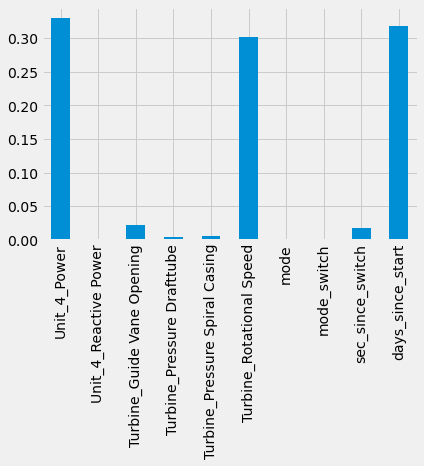

In [55]:
imps.plot(kind="bar")

[Text(939.6, 1069.2, 'X[7] <= 11441473.5\nmse = 669.997\nsamples = 5523972\nvalue = [[1524.16]\n[1455.747]\n[1642.051]\n[1598.662]\n[1631.653]\n[1650.939]]'),
 Text(469.8, 874.8000000000001, 'X[7] <= 6985011.0\nmse = 127.497\nsamples = 3635355\nvalue = [[1493.421]\n[1443.526]\n[1623.145]\n[1597.675]\n[1628.635]\n[1639.93]]'),
 Text(234.9, 680.4000000000001, 'X[7] <= 2848090.5\nmse = 44.669\nsamples = 1904977\nvalue = [[1487.638]\n[1439.781]\n[1608.429]\n[1599.747]\n[1623.583]\n[1630.439]]'),
 Text(117.45, 486.0000000000001, 'X[7] <= 1302764.5\nmse = 20.568\nsamples = 703070\nvalue = [[1492.697]\n[1438.964]\n[1599.97]\n[1602.644]\n[1616.117]\n[1622.7]]'),
 Text(58.725, 291.6, 'X[7] <= 591308.5\nmse = 9.161\nsamples = 430340\nvalue = [[1494.454]\n[1434.821]\n[1596.229]\n[1604.418]\n[1614.716]\n[1621.034]]'),
 Text(29.3625, 97.20000000000005, 'mse = 8.082\nsamples = 190742\nvalue = [[1496.571]\n[1433.387]\n[1593.713]\n[1604.85]\n[1613.571]\n[1618.794]]'),
 Text(88.0875, 97.20000000000005,

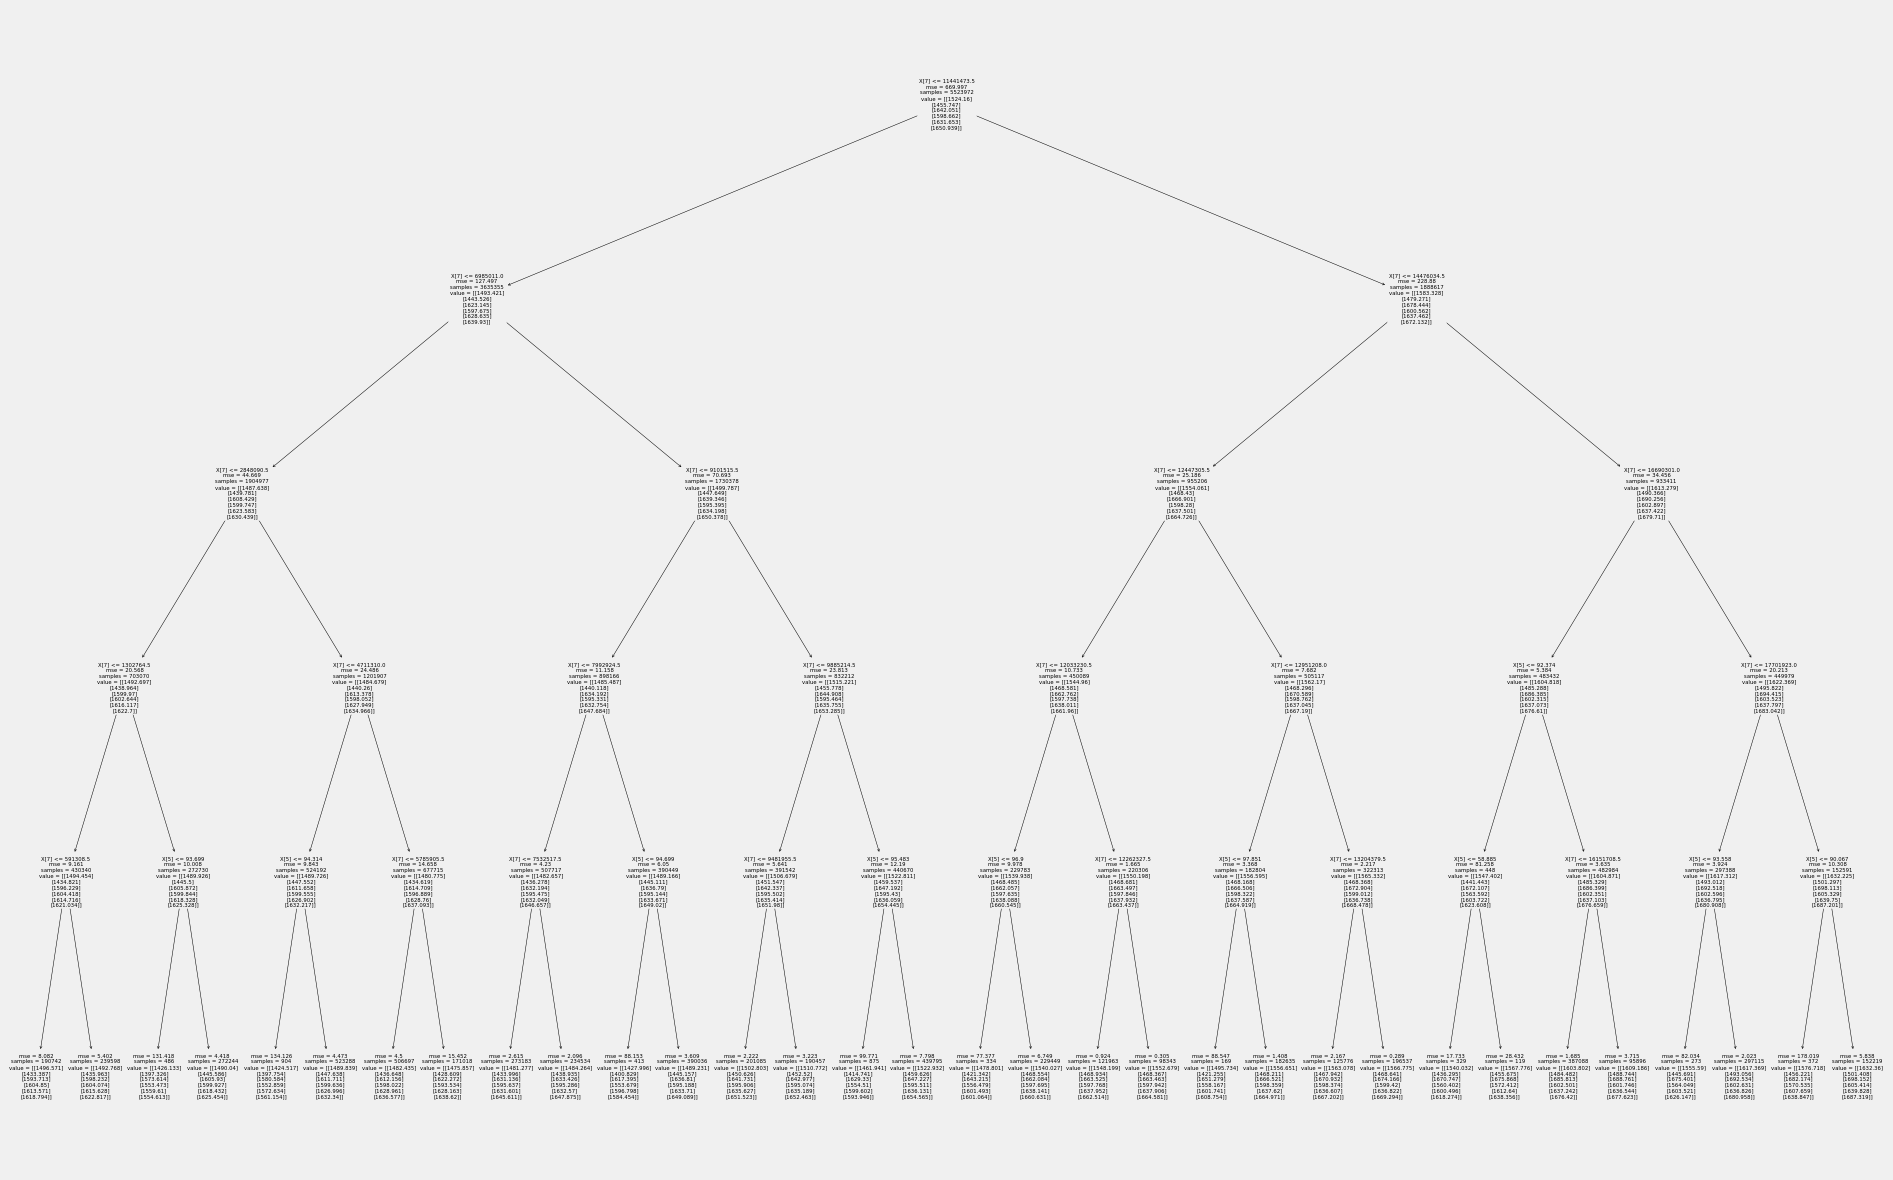

In [89]:
fig = plt.figure(figsize=(30,20))
plot_tree(dt)

In [77]:
df_scores = pd.DataFrame([scores[i]["DecisionTreeRegressor"] for i in range(1,4)], columns=y_cols)

<AxesSubplot:>

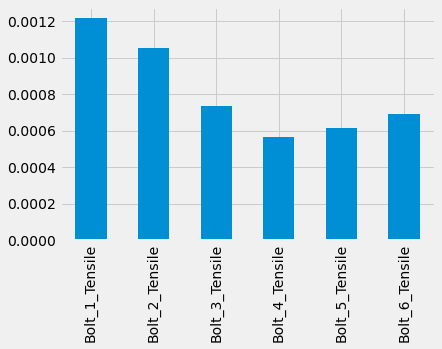

In [82]:
df_scores.mean().plot(kind="bar")

<AxesSubplot:>

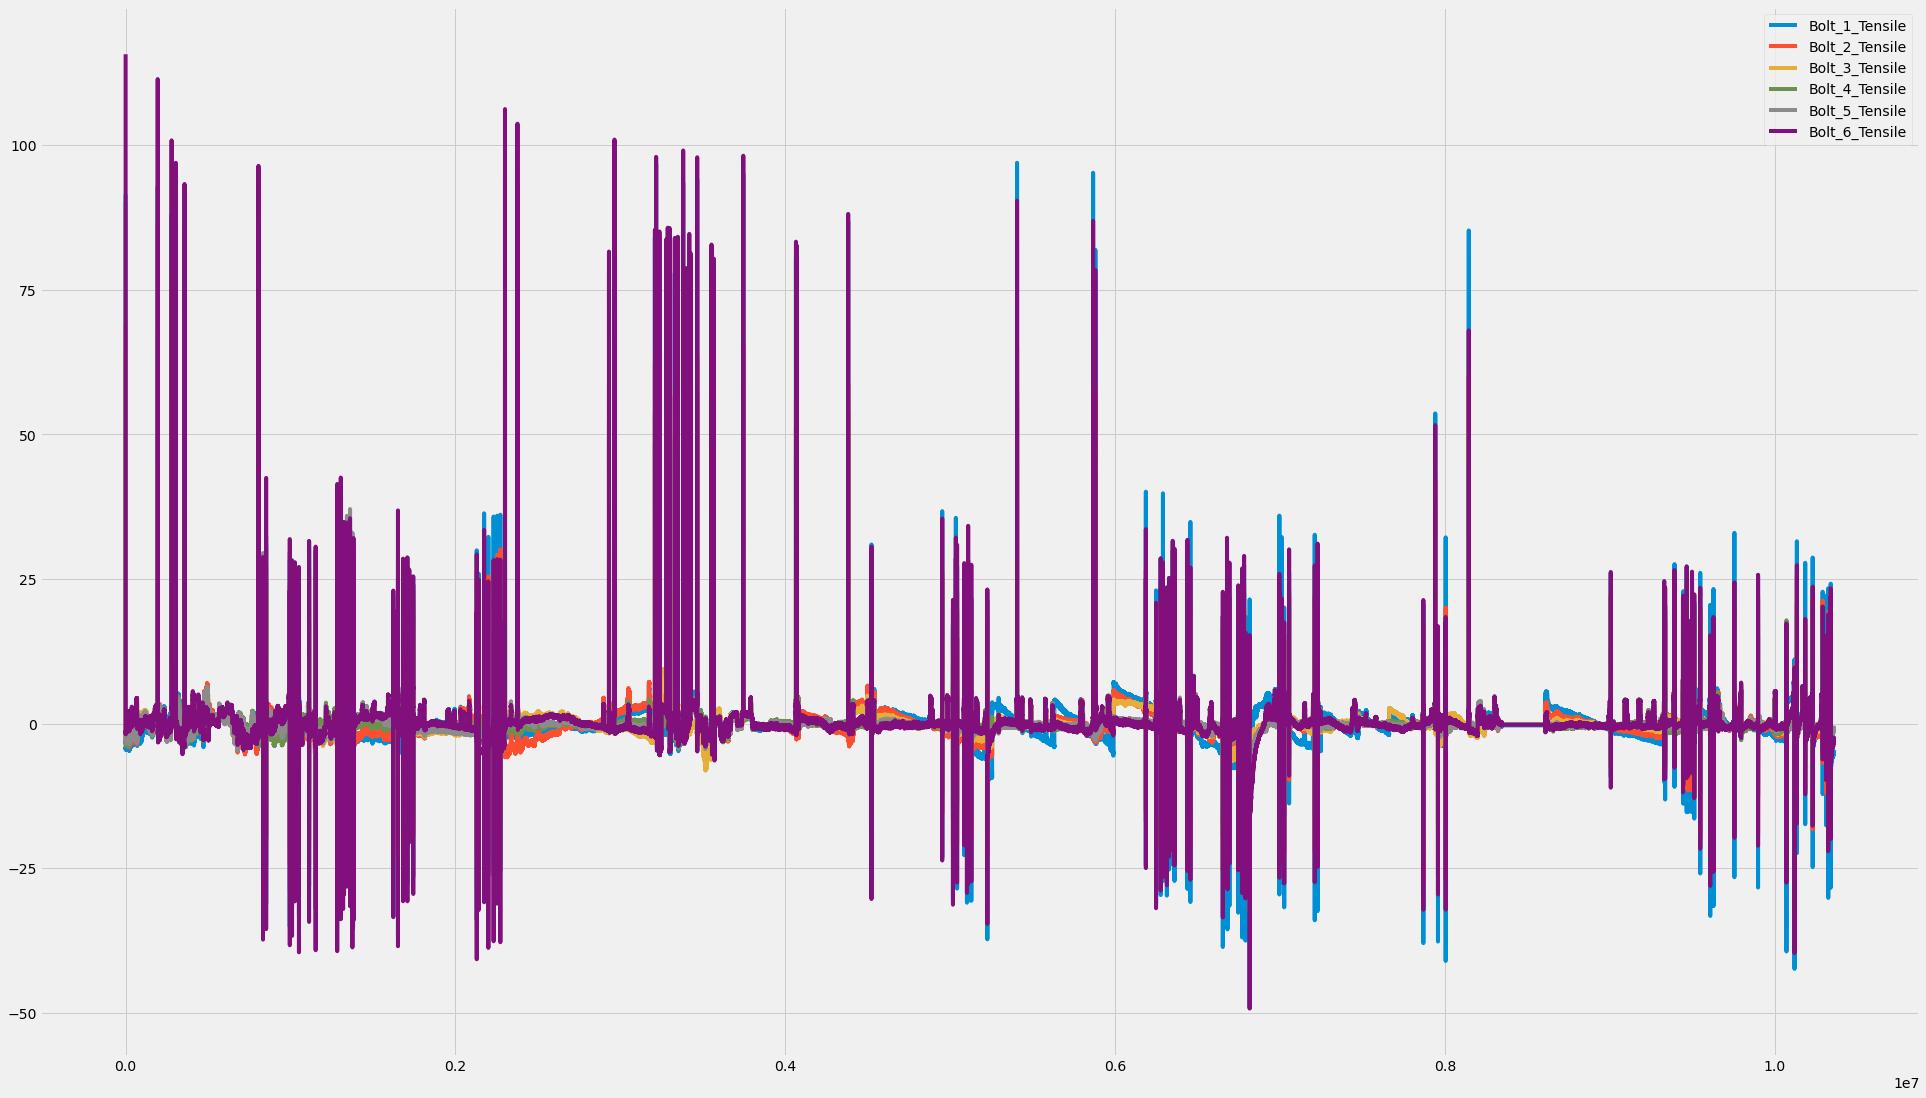

In [93]:
residuals[1]["DecisionTreeRegressor"].plot(figsize=(30,18))

# Make predictions on validation set

In [ ]:
score = {}
preds = {}
residuals = {}
models = {}
for y in y_cols:
    print(y)
    drop_cols = [x for x in y_cols if x!=y]
    y_train = df_y_train.drop(drop_cols, axis=1).values.flatten()
    y_val = df_y_val.drop(drop_cols, axis=1).values.flatten()
    model = RandomForestRegressor(n_estimators=5, n_jobs=4)
    model.fit(df_X_train, y_train)
    y_pred = model.predict(df_X_val)
    score = mean_absolute_percentage_error(y_val, y_pred)
    print(score)
    scores[y] = score
    preds[y] = y_pred
    residuals[y] = y_pred-y_test.values.flatten()
    trained_models[y] = model

Bolt_1_Tensile
